In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd
from pyomo.environ import *
from shapely.geometry import LineString
import itertools
import os
from pyomo import environ as pe

os.environ['NEOS_EMAIL'] = 'XXXXXX@gmail.com' 

In [2]:
Kolors  = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#393b79", "#e6550d", "#637939", "#d6616b", "#843c39",
    "#b5cf6b", "#d62728", "#7b4173", "#ce6dbd", "#bd9e39",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
random.shuffle(Kolors)



# You can access these colors by index, e.g., matplotlib_colors[0] is "b" (blue).


D = pd.read_csv("30x30-16.txt")
D = pd.read_csv("5x5-1.txt")
D = pd.read_csv("002_shikaku.txt")
D = pd.read_csv("003_shikaku.txt")



N = len(D)

init_data = {}
for r in range(N):
    
    #init_data[r] = [int(d) for d in D.iloc[r,0] if d!=' '] 
    my_list = [word.strip() for word in D.iloc[r,0].split(' ')]
    L = []
    for d in my_list:
        if d=='-':
            L.append(0)
        elif d!='':
            L.append(int(d))
    init_data[r] = L
    
init_data 
    
# [4, 4, 6, 8, 1, 2, 2, 8, 8, 8, 2, 2, 1, 2, 4, 2, 2, 8, 8]
init_data

{0: [0, 0, 6, 0, 0, 0, 0, 3, 0, 0],
 1: [0, 4, 0, 0, 0, 0, 0, 0, 4, 0],
 2: [4, 0, 3, 0, 0, 0, 0, 3, 0, 4],
 3: [0, 0, 0, 2, 0, 0, 9, 0, 0, 0],
 4: [0, 0, 0, 0, 2, 3, 0, 0, 0, 0],
 5: [0, 0, 0, 0, 3, 4, 0, 0, 0, 0],
 6: [0, 0, 0, 2, 0, 0, 6, 0, 0, 0],
 7: [6, 0, 3, 0, 0, 0, 0, 4, 0, 6],
 8: [0, 6, 0, 0, 0, 0, 0, 0, 6, 0],
 9: [0, 0, 4, 0, 0, 0, 0, 3, 0, 0]}

In [3]:
data = {}
counter = 0
Nr , Nc= len(init_data[r]), N
print(Nr,Nc)
for r in range(Nc):
    for c in range(Nr):
        s= init_data[r][c]
        counter+=1
        data[counter,'x'] =  c+1
        data[counter,'y'] =  Nr-r
        data[counter,'v'] =  int(s) 

10 10


In [4]:
def dist(D,i,j):
    return ( np.sqrt((D[i,'x'] - D[j,'x'])**2 + (D[i,'y'] - D[j,'y'])**2))
points = [c+1 for c in range(counter)]
cpoints = [c for c in points if data[c,'v']>0]
v_cpoints = [data[c,'v'] for c in points if data[c,'v']>0]

print(cpoints, len(cpoints), sum(v_cpoints))
connect = {}
connect = { (c1,c2):dist(data,c1,c2) for c1 in points for c2 in points if c1!=c2}
print(v_cpoints)

[3, 8, 12, 19, 21, 23, 28, 30, 34, 37, 45, 46, 55, 56, 64, 67, 71, 73, 78, 80, 82, 89, 93, 98] 24 100
[6, 3, 4, 4, 4, 3, 3, 4, 2, 9, 2, 3, 3, 4, 2, 6, 6, 3, 4, 6, 6, 6, 4, 3]


In [5]:
def draw(L, LW=1):
    if LW > 1:
        LW =8
        plt.plot([L[0][0],L[1][0]], [L[0][1],L[1][1]], lw=LW)
    else:
        plt.plot([L[0][0],L[1][0]], [L[0][1],L[1][1]], lw=2, c= 'k')

In [6]:
model = AbstractModel()
Np = len(points)
model.i = RangeSet(Np)
model.j = Set(initialize=model.i)
model.c = Set(initialize = cpoints)

model.U = Var(model.i,model.j,bounds=(0,1),initialize=0, within=Binary)
model.flow = Var(model.c, model.i,model.j,bounds=(0,1),initialize=0, within=Reals)

model.source = Var(model.c,bounds=(0,1),initialize=0, within=Reals)

def rule_C1(model,i):
    return sum( model.U[i,c] for c in model.c) == 1
model.C1 = Constraint(model.i, rule=rule_C1)

def rule_C2(model,c):
    return sum( model.U[i,c] for i in model.i if data[i,'v']==0) ==  data[c,'v']-1
model.C2 = Constraint(model.c, rule=rule_C2)

def rule_C3(model,c,i):
    if data[i,'v']==0 or i ==c:
        if i==c:
            return model.source[c] - model.U[i,c]/Np == sum( model.flow[c,i,j] for j in model.j if dist(data,i,j) ==1)-\
                                                    sum( model.flow[c,j,i] for j in model.j if dist(data,i,j) ==1)
        elif data[i,'v']==0:
             return                - model.U[i,c]/Np == sum( model.flow[c,i,j] for j in model.j if dist(data,i,j) ==1)-\
                                                    sum( model.flow[c,j,i] for j in model.j if dist(data,i,j) ==1)
    else:
        return Constraint.Skip 
model.C3 = Constraint(model.c,model.i, rule=rule_C3)

def rule_C4A(model,c,i,j):
    if  data[i,'v']==0 and data[j,'v']==0 and dist(data,i,j) ==1:
        return model.flow[c,i,j] <= model.U[i,c] 
    else:
        return Constraint.Skip 
model.C4A = Constraint(model.c,model.i,model.j, rule=rule_C4A)


def rule_C4B(model,c,i,j):
    if  data[i,'v']==0 and data[j,'v']==0 and dist(data,i,j) ==1:
        return model.flow[c,i,j] <= model.U[j,c]
    else:
        return Constraint.Skip 
model.C4B = Constraint(model.c,model.i,model.j, rule=rule_C4B)


def rule_OF(model):
    return  sum(model.U[i,c] for i in model.i for c in model.c if (i,c) in connect) 
model.obj1 = Objective(rule=rule_OF, sense=minimize)
instance = model.create_instance()  


In [7]:
opt = SolverFactory('cbc')
opt.options = {'sec': 1600, 'threads': 4, 'ratio': 0.4}

In [8]:
for c1 in instance.i:
    for c2 in instance.i:
        if data[c1,'v']==0 and data[c2,'v']==0:
                #pass
                instance.U[c1,c2].fix(0)
for c1 in instance.c:
    instance.U[c1,c1].fix(1)
for c1 in instance.c:
    for c2 in instance.i:
        if data[c2,'v']==0 and dist(data,c1,c2)>data[c1,'v']:
                #pass 
                instance.U[c2,c1].fix(0)
#"""
for c in instance.c:
    for (i,j) in connect:
        if i!=c and j!=c and data[i,'v'] + data[j,'v'] >0: 
            instance.flow[c,i,j].fix(0)

#"""                
results = opt.solve(instance)

from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal and nothing more")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))
print('OF= ', value(instance.obj1) )

this is feasible and optimal and nothing more
OF=  76.0


3 6 [1, 2, 4, 5, 11]
8 3 [6, 7]
12 4 [13, 14, 22]
19 4 [9, 10, 20]
21 4 [31, 32, 41]
23 3 [33, 43]
28 3 [17, 18]
30 4 [29, 40, 50]
34 2 [24]
37 9 [15, 16, 25, 26, 27, 38, 39, 49]
45 2 [44]
46 3 [35, 36]
55 3 [53, 54]
56 4 [47, 48, 57]
64 2 [63]
67 6 [58, 59, 60, 68, 69]
71 6 [42, 51, 52, 61, 81]
73 3 [62, 72]
78 4 [66, 76, 77]
80 6 [70, 79, 90, 99, 100]
82 6 [65, 74, 75, 83, 84]
89 6 [85, 86, 87, 88, 95]
93 4 [91, 92, 94]
98 3 [96, 97]


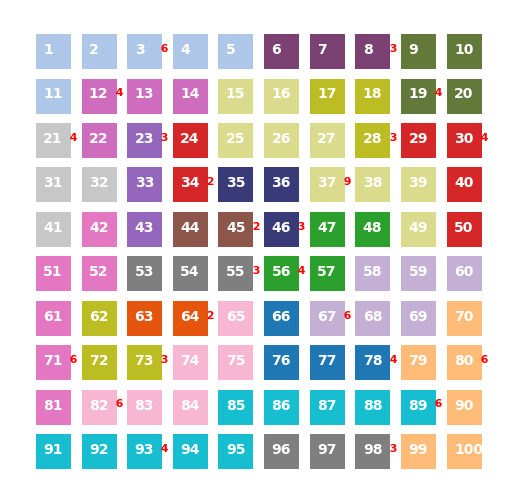

In [9]:
plt.figure(figsize=(9,9))
plt.xticks(range(1,1+Nr))
plt.yticks(range(2,2+Nc))
plt.xlim(0,Nr+1)
plt.ylim(0,Nc+1)
node_size = 1200
plt.axis('off')
c_index = 0 
counter =1 
for i in instance.i:
    plt.text(data[i,'x']-0.21,data[i,'y']-0.05, s=f"{i}" , fontsize=14,c ='w', fontweight='bold')
    if data[i,'v']==0:
        plt.scatter(data[i,'x'],data[i,'y'], s=node_size,marker ='s' , c='grey', alpha=0.2)
    else:
        plt.scatter(data[i,'x'],data[i,'y'], s=node_size,marker ='s' , c=Kolors[c_index])
        plt.text(data[i,'x']+0.2,data[i,'y'], s=f"  {data[i,'v']}", fontsize=11,c ='r', fontweight='bold')
        c_index+=1

plt.savefig(f'shikaku base .png', format='png', dpi=400)

c_index = 0 

for c in instance.c:
    a= [j for j in instance.j if (j,c) in connect and value(instance.U[j,c])>0]
    print(c,data[c,'v'],a)
    for j in a+[c]:
        plt.scatter(data[j,'x'],data[j,'y'], s=node_size,marker ='s' , c=Kolors[c_index])
    counter+=1
    c_index+=1

plt.savefig(f'shikaku {counter} .png', format='png', dpi=200)

plt.show()

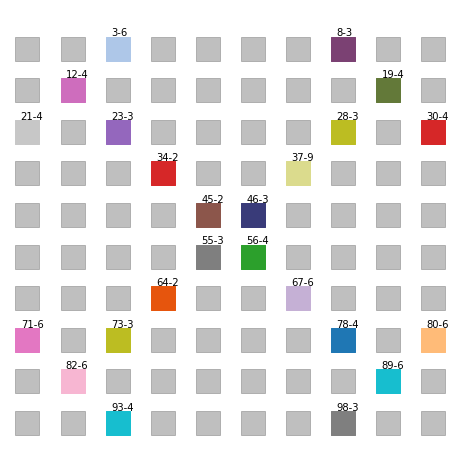

In [10]:
plt.figure(figsize=(8,8))
c_index = 0 
for i in instance.i:
    if data[i,'v']==0:
        plt.scatter(data[i,'x'],data[i,'y'], s=600,marker ='s' , c='grey', alpha=0.5)
    if data[i,'v']>0:
        plt.text(data[i,'x']-0.15,data[i,'y']+0.3, s=f"{i}-{data[i,'v']}")
        a= [j for j in instance.j if (j,i) in connect and value(instance.U[j,i])>0]
        for j in [i]:
            plt.scatter(data[j,'x'],data[j,'y'], s=600,marker ='s' , c=Kolors[c_index])
        c_index+=1
plt.xticks(range(1,1+Nr))
plt.yticks(range(2,2+Nc))
plt.axis('off')
plt.show()

0  0 0 8 0 0
1  0 0 0 0 0
2  6 0 4 0 4
3  0 0 0 0 0
4  0 0 3 0 0